# Assignment 3 - Galhena_Appuhamilage_Dona_Sayumi_Kusalya_De_Alwis_a1985986



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import random
import numpy as np
from PIL import Image, ImageStat
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import OrderedDict


def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**Paths and hyperparameters**

In [3]:
TRAIN_DIR = "/content/drive/MyDrive/Assignment_3_material/train"
TEST_DIR  = "/content/drive/MyDrive/Assignment_3_material/test"

CLASS_MAP_PATH = "/content/drive/MyDrive/Assignment_3_material/class_map.json"

with open(CLASS_MAP_PATH, 'r') as file:
    class_map = json.load(file)

id_to_class = {v: k for k, v in class_map.items()}

NUM_CLASSES = len(class_map)
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS_BASELINE1 = 40
EPOCHS_BASELINE2 = 40
EPOCHS_MAIN      = 60
EPOCHS_AB = 40

LEARNING_RATE = 1e-3
WEIGHT_DECAY  = 1e-4

MEAN = [0.5, 0.5, 0.5]
STD  = [0.5, 0.5, 0.5]

print("Classes:",class_map)


Classes: {'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6, 'platelet': 7}


# **Preprocessing**

**Data Preparation and Visualization**

Class distribution: {'basophil': 400, 'eosinophil': 400, 'erythroblast': 400, 'ig': 400, 'lymphocyte': 400, 'monocyte': 400, 'neutrophil': 400, 'platelet': 400}


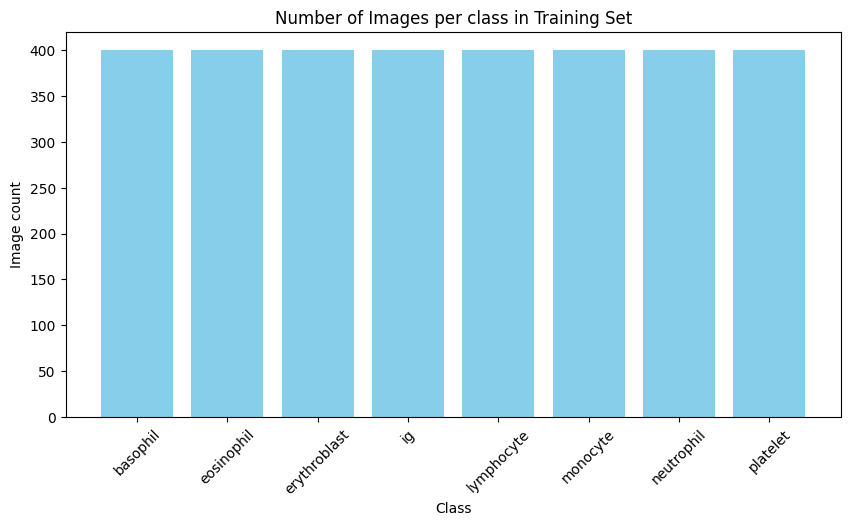

In [4]:
# ------------------- Class Distribution Visualization -----------------

class_counts = {}

for cls in sorted(os.listdir(TRAIN_DIR)):
  class_path = os.path.join(TRAIN_DIR, cls)
  if os.path.isdir(class_path):
    class_counts[cls] = len(os.listdir(class_path))

print("Class distribution:", class_counts)

plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Number of Images per class in Training Set")
plt.xlabel("Class")
plt.ylabel("Image count")
plt.xticks(rotation=45)
plt.show()

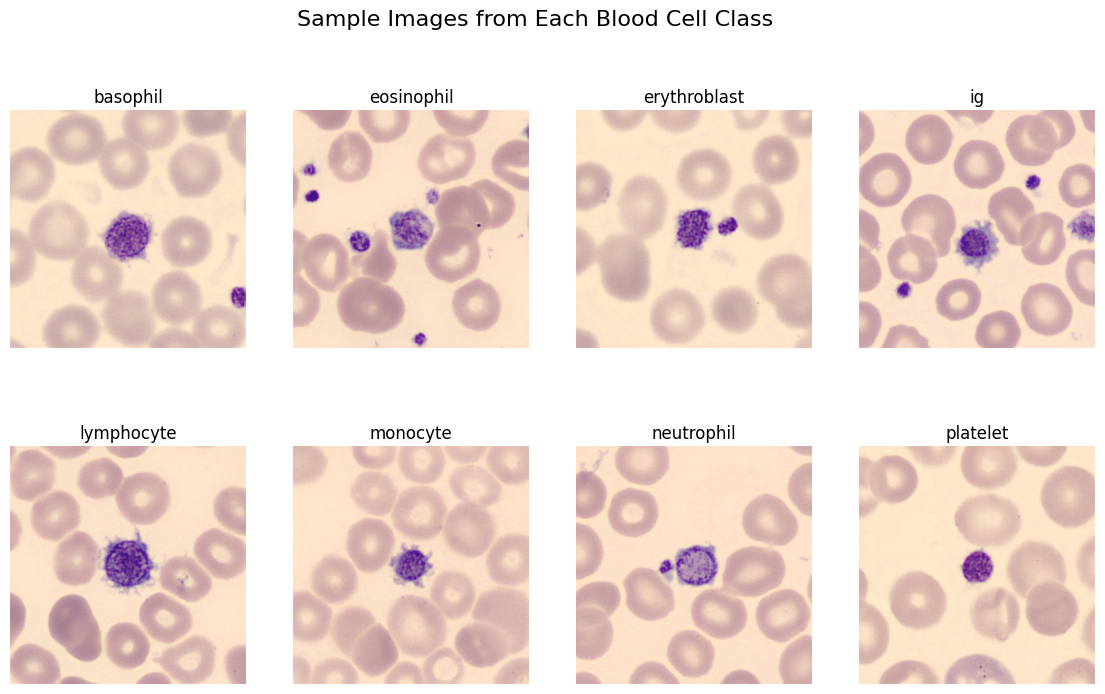

In [5]:
# ------------------- Sample Images Visualization from each class-----------------

plt.figure(figsize=(14,8))

for i, cls in enumerate(class_counts.keys()):
  clss_path = os.path.join(TRAIN_DIR, cls)
  img_name = random.choice(os.listdir(class_path))
  img_path = os.path.join(class_path, img_name)

  img = Image.open(img_path)

  plt.subplot(2, 4, i+1)
  plt.imshow(img)
  plt.title(cls)
  plt.axis('off')

plt.suptitle("Sample Images from Each Blood Cell Class", fontsize=16)
plt.show()



In [6]:
# ------------------- Feature Statistics (image per class) -----------------

heights = []
widths = []

for cls in class_counts.keys():
  cls_path = os.path.join(TRAIN_DIR, cls)
  for img_name in os.listdir(cls_path):
      img_path = os.path.join(cls_path, img_name)
      img = Image.open(img_path)
      w, h = img.size
      widths.append(w)
      heights.append(h)
      break

print("Image width samples sizes", widths)
print("Image height samples sizes", heights)

Image width samples sizes [360, 360, 360, 360, 360, 360, 360, 360]
Image height samples sizes [363, 363, 360, 363, 363, 363, 363, 363]


In [7]:
# ------------------- Dataset Summary -----------------

train_total = sum(class_counts.values())
test_total = len(os.listdir(TEST_DIR))

print(f"Total Train Images : {train_total}")
print(f"Total Unlabelled Test Images :  {test_total}")

Total Train Images : 3200
Total Unlabelled Test Images :  1000


**Data Cleaning**

In [8]:
# --------- Check for corrupted or invalid images ----------------

def check_and_clean_images(folder):
    bad_images = []

    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if not os.path.isdir(cls_path):
            continue

        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)

            try:
                # Load the image
                img = Image.open(img_path).convert("RGB")

                # Check for invalid dimensions
                if img.size[0] < 5 or img.size[1] < 5:
                    bad_images.append((img_path, "Invalid size"))
                    continue

                # Compute image statistics
                stat = ImageStat.Stat(img)
                mean = stat.mean
                stddev = stat.stddev

                # Check image is completely black
                if all(m == 0 for m in mean):
                    bad_images.append((img_path, "Black image"))
                    continue

                # Check image is completely white
                if all(m == 255 for m in mean):
                    bad_images.append((img_path, "White image"))
                    continue

                # Check almost blank
                if all(s < 2.0 for s in stddev):
                    bad_images.append((img_path, "Low variance / blank"))
                    continue

            except Exception as e:
                # Catch corrupted or unreadable image files
                bad_images.append((img_path, f"Corrupted or unreadable ({e})"))

    return bad_images

bad_train = check_and_clean_images(TRAIN_DIR)

print("DATA CLEANING REPORT\n")
print("Total bad images found:", len(bad_train))

if bad_train:
    for path, reason in bad_train[:10]:
        print(f"{path} --> {reason}")
else:
    print("All images passed validation.")

DATA CLEANING REPORT

Total bad images found: 0
All images passed validation.


**Data Transforms and Dataloaders**

In [9]:
full_train_dataset = datasets.ImageFolder(TRAIN_DIR)

# Data split
indices = np.arange(len(full_train_dataset))
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.20,
    stratify=full_train_dataset.targets,
    random_state=42
)

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(
        brightness=0.25,
        contrast=0.25,
        saturation=0.25,
        hue=0.05
    ),
    transforms.RandomAutocontrast(p=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset   = datasets.ImageFolder(TRAIN_DIR, transform=val_transform)

train_subset = Subset(train_dataset, train_idx)
val_subset   = Subset(val_dataset, val_idx)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Train samples:", len(train_subset))
print("Val samples:", len(val_subset))
print("Classes (ImageFolder):", train_dataset.classes)

Train samples: 2560
Val samples: 640
Classes (ImageFolder): ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


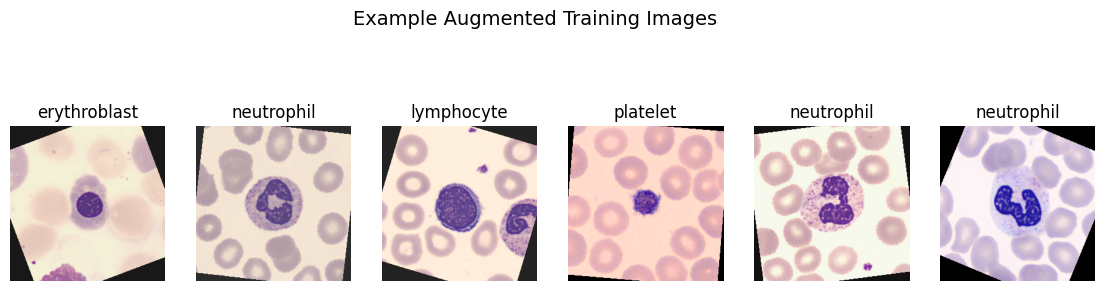

In [10]:
# -------- Visualize Augmented Images in Train loader ----------

def show_augmented_batch(loader, classes, n=6):

    images, labels = next(iter(loader))
    plt.figure(figsize=(14,4))
    plt.suptitle("Example Augmented Training Images", fontsize=14)

    for i in range(n):
        img = images[i].permute(1,2,0)
        img = (img * torch.tensor(STD) + torch.tensor(MEAN)).clamp(0,1)

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(classes[labels[i].item()])
        plt.axis("off")

    plt.show()

show_augmented_batch(train_loader, train_dataset.classes, n=6)


# **Model Implementation**

**Baseline Model 1 – Simple CNN**

In [11]:
class SimpleCNN(nn.Module):
    """
    Baseline CNN with two conv blocks and a simple classifier.
    """
    def __init__(self, num_classes=8):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 256 -> 128

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 128 -> 64
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x


**Baseline Model 2 – Deeper CNN**

In [12]:
class DeepCNN(nn.Module):
    """
    Stronger baseline: more conv blocks, more filters, dropout.
    """
    def __init__(self, num_classes=8):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 256 -> 128

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 128 -> 64

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 64 -> 32

            # Block 4
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 32 -> 16
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x


**Main Model – U-Net-Style Encoder Classifier**

In [13]:
class DoubleConv(nn.Module):
    """
    Two consecutive 3x3 conv + BN + ReLU, as in U-Net encoder.
    """
    def __init__(self, in_c, out_c):
        super().__init__()
        # First conv extracts low-level patterns and BatchNorm stabilizes tarining
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),

        # Second conv extracts more abstract features and BatchNorm stabilizes tarining
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

# Main model
class UNetEncoderClassifier(nn.Module):
    """
    Use U-Net style encoder (downsampling path) for feature extraction,
    then global average pooling + dense classifier for 8-class classification.
    """
    # Hybrid Unet and CNN architecture

    def __init__(self, num_classes=8, base_c=32):
        super().__init__()
        # Encoder (U-Net style)
        self.enc1 = DoubleConv(3, base_c)         # 3 -> 32
        self.pool1 = nn.MaxPool2d(2)              # 256 -> 128

        self.enc2 = DoubleConv(base_c, base_c*2)  # 32 -> 64
        self.pool2 = nn.MaxPool2d(2)              # 128 -> 64

        self.enc3 = DoubleConv(base_c*2, base_c*4)  # 64 -> 128
        self.pool3 = nn.MaxPool2d(2)                # 64 -> 32

        self.enc4 = DoubleConv(base_c*4, base_c*8)  # 128 -> 256
        self.pool4 = nn.MaxPool2d(2)                # 32 -> 16

        # Bottleneck - captures global patterns
        self.bottleneck = DoubleConv(base_c*8, base_c*16)  # 256 -> 512

        # Classification head
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Reduces overfitting
        self.dropout = nn.Dropout(0.5)

        # Classify with a linear layer
        self.fc = nn.Linear(base_c*16, num_classes)

    def forward(self, x):
        # Encoder path (we ignore decoder for classification)
        x = self.enc1(x)
        x = self.pool1(x)

        x = self.enc2(x)
        x = self.pool2(x)

        x = self.enc3(x)
        x = self.pool3(x)

        x = self.enc4(x)
        x = self.pool4(x)

        x = self.bottleneck(x)

        # Global pooling + classification
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


**Training & Evaluation Utilities**

In [14]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(out, dim=1)
        running_loss += loss.item() * y.size(0)
        running_correct += (preds == y).sum().item()
        running_total += y.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc  = running_correct / running_total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    all_true = []
    all_pred = []

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        loss = criterion(out, y)

        _, preds = torch.max(out, dim=1)
        running_loss += loss.item() * y.size(0)
        running_correct += (preds == y).sum().item()
        running_total += y.size(0)

        all_true.extend(y.cpu().tolist())
        all_pred.extend(preds.cpu().tolist())

    epoch_loss = running_loss / running_total
    epoch_acc  = running_correct / running_total
    return epoch_loss, epoch_acc, all_true, all_pred


def fit(model, train_loader, val_loader, epochs, name, use_label_smoothing=False):
    """
    Train a given model and save the best state (by val accuracy).
    If use_label_smoothing=True, applies CE with label_smoothing=0.1.
    """
    if use_label_smoothing:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=3
    )

    best_acc = 0.0
    best_state = None
    history = {"val_acc":[]}

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)

        scheduler.step(val_loss)

        history["val_acc"].append(val_acc)

        print(
            f"[{name}] Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.3f} | "
            f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.3f}"
        )

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = model.state_dict()
            torch.save(best_state, f"best_{name}.pt")
            print(f"Best model updated (Val Acc = {best_acc:.4f})")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_acc, history


**Train Baseline 1 - Simple CNN**

In [15]:
baseline1 = SimpleCNN(num_classes=NUM_CLASSES).to(device)
baseline1, best_acc_b1, baseline1_history = fit(
    baseline1,
    train_loader,
    val_loader,
    epochs=EPOCHS_BASELINE1,
    name="baseline_simple_cnn",
    use_label_smoothing=False
)


[baseline_simple_cnn] Epoch 1/40 | Train Loss: 2.0032 Train Acc: 0.213 | Val Loss: 1.9333 Val Acc: 0.222
Best model updated (Val Acc = 0.2219)
[baseline_simple_cnn] Epoch 2/40 | Train Loss: 1.9165 Train Acc: 0.282 | Val Loss: 1.8870 Val Acc: 0.269
Best model updated (Val Acc = 0.2687)
[baseline_simple_cnn] Epoch 3/40 | Train Loss: 1.8425 Train Acc: 0.323 | Val Loss: 1.7938 Val Acc: 0.295
Best model updated (Val Acc = 0.2953)
[baseline_simple_cnn] Epoch 4/40 | Train Loss: 1.7946 Train Acc: 0.327 | Val Loss: 1.7278 Val Acc: 0.350
Best model updated (Val Acc = 0.3500)
[baseline_simple_cnn] Epoch 5/40 | Train Loss: 1.7435 Train Acc: 0.352 | Val Loss: 1.6882 Val Acc: 0.355
Best model updated (Val Acc = 0.3547)
[baseline_simple_cnn] Epoch 6/40 | Train Loss: 1.6763 Train Acc: 0.383 | Val Loss: 1.6196 Val Acc: 0.383
Best model updated (Val Acc = 0.3828)
[baseline_simple_cnn] Epoch 7/40 | Train Loss: 1.6450 Train Acc: 0.380 | Val Loss: 1.7323 Val Acc: 0.275
[baseline_simple_cnn] Epoch 8/40 | Tr

**Train Baseline 2 - Deeper CNN**

In [16]:
baseline2 = DeepCNN(num_classes=NUM_CLASSES).to(device)
baseline2, best_acc_b2, baseline2_history = fit(
    baseline2,
    train_loader,
    val_loader,
    epochs=EPOCHS_BASELINE2,
    name="baseline_deep_cnn",
    use_label_smoothing=False
)


[baseline_deep_cnn] Epoch 1/40 | Train Loss: 1.9280 Train Acc: 0.235 | Val Loss: 1.8884 Val Acc: 0.184
Best model updated (Val Acc = 0.1844)
[baseline_deep_cnn] Epoch 2/40 | Train Loss: 1.6543 Train Acc: 0.315 | Val Loss: 2.0594 Val Acc: 0.169
[baseline_deep_cnn] Epoch 3/40 | Train Loss: 1.4933 Train Acc: 0.400 | Val Loss: 1.4633 Val Acc: 0.366
Best model updated (Val Acc = 0.3656)
[baseline_deep_cnn] Epoch 4/40 | Train Loss: 1.3897 Train Acc: 0.450 | Val Loss: 1.5327 Val Acc: 0.353
[baseline_deep_cnn] Epoch 5/40 | Train Loss: 1.2690 Train Acc: 0.513 | Val Loss: 2.3057 Val Acc: 0.233
[baseline_deep_cnn] Epoch 6/40 | Train Loss: 1.2087 Train Acc: 0.546 | Val Loss: 1.6089 Val Acc: 0.328
[baseline_deep_cnn] Epoch 7/40 | Train Loss: 1.1522 Train Acc: 0.571 | Val Loss: 1.1243 Val Acc: 0.522
Best model updated (Val Acc = 0.5219)
[baseline_deep_cnn] Epoch 8/40 | Train Loss: 1.0994 Train Acc: 0.593 | Val Loss: 0.8658 Val Acc: 0.733
Best model updated (Val Acc = 0.7328)
[baseline_deep_cnn] Epoc

**Train the Main U-Net Encoder Classifier**

In [17]:
main_model = UNetEncoderClassifier(num_classes=NUM_CLASSES, base_c=32).to(device)

main_model, best_acc_main, main_history = fit(
    main_model,
    train_loader,
    val_loader,
    epochs=EPOCHS_MAIN,
    name="unet_encoder_main",
    use_label_smoothing=True
)


[unet_encoder_main] Epoch 1/60 | Train Loss: 1.7944 Train Acc: 0.331 | Val Loss: 1.7815 Val Acc: 0.244
Best model updated (Val Acc = 0.2437)
[unet_encoder_main] Epoch 2/60 | Train Loss: 1.4631 Train Acc: 0.505 | Val Loss: 1.6699 Val Acc: 0.455
Best model updated (Val Acc = 0.4547)
[unet_encoder_main] Epoch 3/60 | Train Loss: 1.3757 Train Acc: 0.581 | Val Loss: 1.8709 Val Acc: 0.269
[unet_encoder_main] Epoch 4/60 | Train Loss: 1.1893 Train Acc: 0.694 | Val Loss: 1.0155 Val Acc: 0.800
Best model updated (Val Acc = 0.8000)
[unet_encoder_main] Epoch 5/60 | Train Loss: 1.0617 Train Acc: 0.747 | Val Loss: 1.7783 Val Acc: 0.500
[unet_encoder_main] Epoch 6/60 | Train Loss: 1.0246 Train Acc: 0.767 | Val Loss: 1.0779 Val Acc: 0.705
[unet_encoder_main] Epoch 7/60 | Train Loss: 0.9636 Train Acc: 0.793 | Val Loss: 1.6200 Val Acc: 0.656
[unet_encoder_main] Epoch 8/60 | Train Loss: 0.9502 Train Acc: 0.809 | Val Loss: 2.1658 Val Acc: 0.598
[unet_encoder_main] Epoch 9/60 | Train Loss: 0.8627 Train Acc:

# **Experiments**

**Model Evaluations**

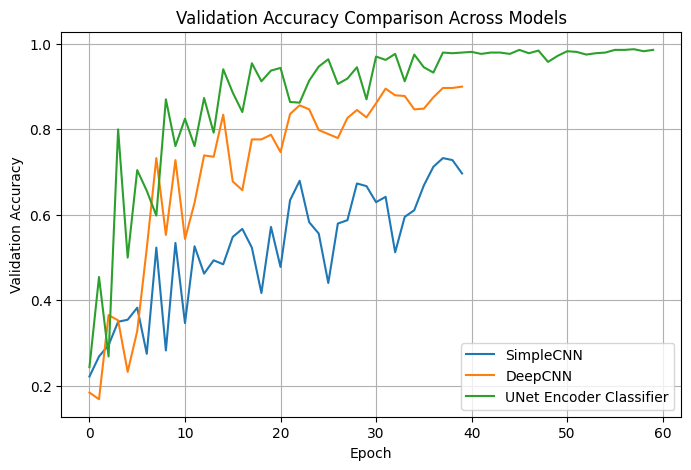

In [18]:
def plot_combined_validation_accuracy(h1, h2, h3, labels):
    plt.figure(figsize=(8,5))

    plt.plot(h1["val_acc"], label=f"{labels[0]}")
    plt.plot(h2["val_acc"], label=f"{labels[1]}")
    plt.plot(h3["val_acc"], label=f"{labels[2]}")

    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy Comparison Across Models")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_combined_validation_accuracy(
    baseline1_history,
    baseline2_history,
    main_history,
    labels=["SimpleCNN", "DeepCNN", "UNet Encoder Classifier"]
)

**Baseline models detailed Metrics on Validation Set**

Baseline1 Validation Accuracy: 0.696875

Classification Report:

              precision    recall  f1-score   support

    basophil       0.85      0.29      0.43        80
  eosinophil       0.92      0.95      0.93        80
erythroblast       0.69      0.78      0.73        80
          ig       0.50      0.36      0.42        80
  lymphocyte       0.57      0.62      0.60        80
    monocyte       0.50      0.86      0.63        80
  neutrophil       0.80      0.74      0.77        80
    platelet       0.95      0.97      0.96        80

    accuracy                           0.70       640
   macro avg       0.72      0.70      0.68       640
weighted avg       0.72      0.70      0.68       640



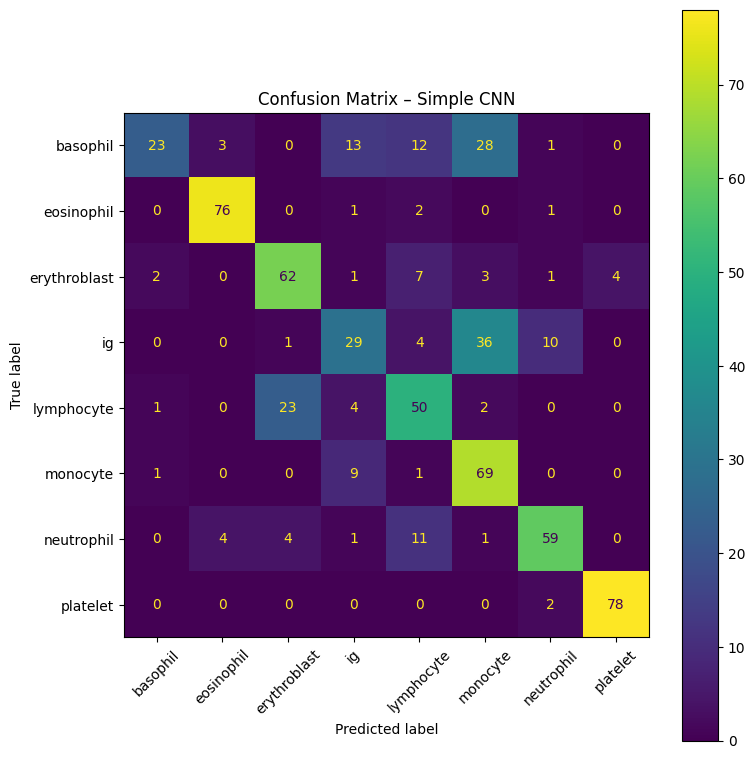

In [19]:
# Evaluate Baseline1 model with best weights loaded
criterion = nn.CrossEntropyLoss()
val_loss, val_acc, y_true, y_pred = evaluate(baseline1, val_loader, criterion)

print("Baseline1 Validation Accuracy:", val_acc)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix – Simple CNN")
plt.tight_layout()
plt.show()


Final Baseline2 Model Validation Accuracy: 0.9

Classification Report:

              precision    recall  f1-score   support

    basophil       0.91      0.96      0.93        80
  eosinophil       1.00      0.99      0.99        80
erythroblast       0.94      0.82      0.88        80
          ig       0.76      0.59      0.66        80
  lymphocyte       0.92      0.95      0.93        80
    monocyte       0.79      0.91      0.85        80
  neutrophil       0.90      0.99      0.94        80
    platelet       0.98      0.99      0.98        80

    accuracy                           0.90       640
   macro avg       0.90      0.90      0.90       640
weighted avg       0.90      0.90      0.90       640



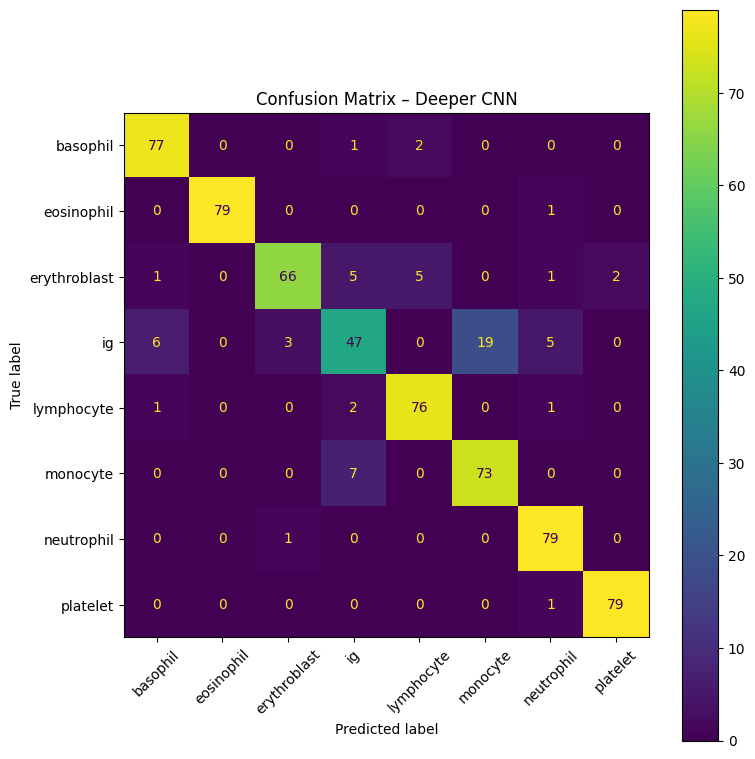

In [20]:
# Evaluate Baseline2 model with best weights loaded
criterion = nn.CrossEntropyLoss()
val_loss, val_acc, y_true, y_pred = evaluate(baseline2, val_loader, criterion)

print("Final Baseline2 Model Validation Accuracy:", val_acc)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix – Deeper CNN")
plt.tight_layout()
plt.show()


**Main Model detailed Metrics on Validation Set**

Final Main Model Validation Accuracy: 0.9859375

Classification Report:

              precision    recall  f1-score   support

    basophil       0.99      1.00      0.99        80
  eosinophil       1.00      1.00      1.00        80
erythroblast       1.00      0.96      0.98        80
          ig       0.99      0.95      0.97        80
  lymphocyte       0.96      1.00      0.98        80
    monocyte       0.95      0.99      0.97        80
  neutrophil       1.00      0.99      0.99        80
    platelet       1.00      1.00      1.00        80

    accuracy                           0.99       640
   macro avg       0.99      0.99      0.99       640
weighted avg       0.99      0.99      0.99       640



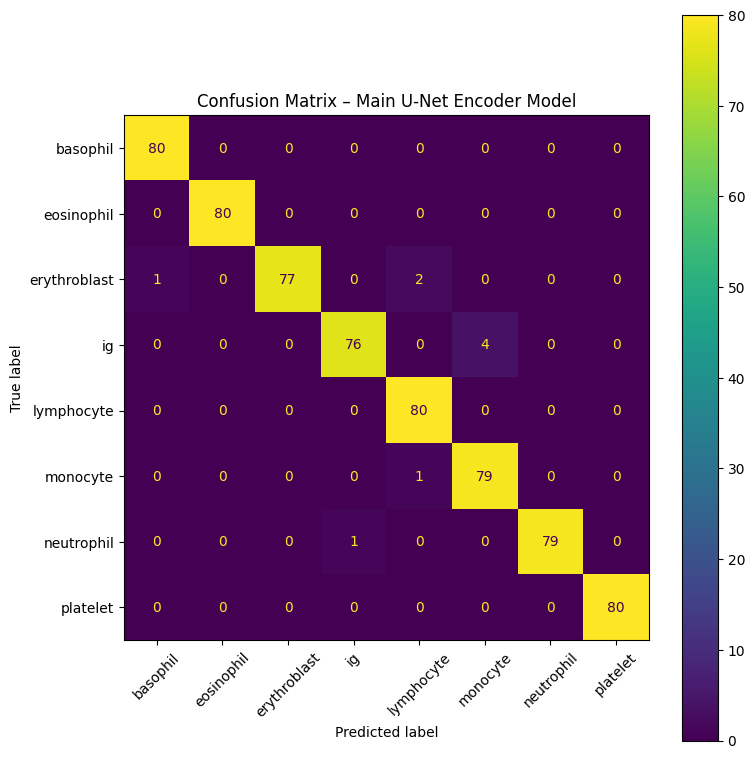

In [21]:
# Evaluate main model with best weights loaded
criterion_main = nn.CrossEntropyLoss(label_smoothing=0.1)
val_loss, val_acc, y_true, y_pred = evaluate(main_model, val_loader, criterion_main)

print("Final Main Model Validation Accuracy:", val_acc)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix – Main U-Net Encoder Model")
plt.tight_layout()
plt.show()


**Generate prediction_labels.json**

In [22]:
# FINAL SUBMISSION – prediction_labels.json

main_model.load_state_dict(torch.load("best_unet_encoder_main.pt", map_location=device))
main_model.eval()

# Generate predictions
predictions = {}

test_images = sorted(os.listdir(TEST_DIR))

for fname in test_images:
    path = os.path.join(TEST_DIR, fname)
    img = Image.open(path).convert("RGB")
    x = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = main_model(x)
        pred = int(out.argmax(1).item())

    predictions[fname] = pred


# Sort the json by image number
def extract_index(filename):

    return int(filename.split('_')[1].split('.')[0])

sorted_predictions = OrderedDict(
    sorted(predictions.items(), key=lambda x: extract_index(x[0]))
)

# Write sorted json file
output_file = "prediction_labels.json"

with open(output_file, "w") as f:
    json.dump(sorted_predictions, f, indent=4)

print(f"Created sorted JSON: {output_file}")
print("Total image labels:", len(sorted_predictions))

Created sorted JSON: prediction_labels.json
Total image labels: 1000


### **Ablation Study**

**Ablation A - No BatchNorm**

In [23]:
class DoubleConv_NoBN(nn.Module):
    """
    Ablation A - Double 3×3 convs without Batch Normalisaltion.

    Purpose of this ablation study is to test the role of Batch
    Normalisation in stabilising training, improving gradient flow
    and speeding up convergence.
    By removing BN we can see whether the main model's high performance
    is dependent on this Batch Normalisation step.

    """
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=True), # No BN
            nn.ReLU(inplace=True),

            nn.Conv2d(out_c, out_c, 3, padding=1, bias=True), # No BN
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNet_NoBN(nn.Module):
    """
    Ablation A - U-Net encoder classifier WITHOUT BatchNorm layers.

    Purpose of this ablation study is to test the role of Batch
    Normalisation by removing it entirely from the encoder
    and bottleneck blocks.

    """
    def __init__(self, num_classes=8, base_c=32):
        super().__init__()
        self.enc1 = DoubleConv_NoBN(3, base_c)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv_NoBN(base_c, base_c*2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv_NoBN(base_c*2, base_c*4)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv_NoBN(base_c*4, base_c*8)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck is also without BN
        self.bottleneck = DoubleConv_NoBN(base_c*8, base_c*16)

        # Classification head remains unchanged.
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(base_c*16, num_classes)

    def forward(self, x):
        # Standard encoder but without BN anywhere
        x = self.pool1(self.enc1(x))
        x = self.pool2(self.enc2(x))
        x = self.pool3(self.enc3(x))
        x = self.pool4(self.enc4(x))
        x = self.bottleneck(x)

        # Classification head
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)


In [24]:
ablation_1_model = UNet_NoBN(num_classes=NUM_CLASSES, base_c=32).to(device)

ablation_1_model, best_acc_ab_1, ab1_history = fit(
    ablation_1_model,
    train_loader,
    val_loader,
    epochs=EPOCHS_AB,
    name="unet_encoder_without_batch_norm",
    use_label_smoothing=True
)

[unet_encoder_without_batch_norm] Epoch 1/40 | Train Loss: 2.0809 Train Acc: 0.121 | Val Loss: 2.0796 Val Acc: 0.125
Best model updated (Val Acc = 0.1250)
[unet_encoder_without_batch_norm] Epoch 2/40 | Train Loss: 2.0801 Train Acc: 0.127 | Val Loss: 2.0795 Val Acc: 0.125
[unet_encoder_without_batch_norm] Epoch 3/40 | Train Loss: 2.0799 Train Acc: 0.118 | Val Loss: 2.0795 Val Acc: 0.125
[unet_encoder_without_batch_norm] Epoch 4/40 | Train Loss: 2.0798 Train Acc: 0.121 | Val Loss: 2.0795 Val Acc: 0.125
[unet_encoder_without_batch_norm] Epoch 5/40 | Train Loss: 2.0798 Train Acc: 0.120 | Val Loss: 2.0794 Val Acc: 0.125
[unet_encoder_without_batch_norm] Epoch 6/40 | Train Loss: 2.0797 Train Acc: 0.124 | Val Loss: 2.0795 Val Acc: 0.125
[unet_encoder_without_batch_norm] Epoch 7/40 | Train Loss: 2.0796 Train Acc: 0.126 | Val Loss: 2.0795 Val Acc: 0.125
[unet_encoder_without_batch_norm] Epoch 8/40 | Train Loss: 2.0797 Train Acc: 0.116 | Val Loss: 2.0795 Val Acc: 0.125
[unet_encoder_without_batc

**Ablation B - No Dropout**

In [25]:
class UNet_NoDropout(nn.Module):
    """

    Ablation B - U-Net encoder classifier WITHOUT dropout.

    Purpose of this ablation is to remove the dropout layer in the
    classifier head to evaluate the contribution of dropout to
    prevent overfitting.
    By eliminating dropout we can see whether the model
    becomes more sensitive to noise, less generalisable
    or try to memorize data.

    """
    def __init__(self, num_classes=8, base_c=32):
        super().__init__()

        # Standard encoder same as main model
        self.enc1 = DoubleConv(3, base_c) # Use DobleCon with BN from Main model
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(base_c, base_c*2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(base_c*2, base_c*4)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(base_c*4, base_c*8)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck unchanged
        self.bottleneck = DoubleConv(base_c*8, base_c*16)

        # Classification head without dropout
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_c*16, num_classes)

    def forward(self, x):
        x = self.pool1(self.enc1(x))
        x = self.pool2(self.enc2(x))
        x = self.pool3(self.enc3(x))
        x = self.pool4(self.enc4(x))
        x = self.bottleneck(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


In [26]:
ablation_2_model = UNet_NoDropout(num_classes=NUM_CLASSES, base_c=32).to(device)

ablation_2_model, best_acc_ab_2, ab2_history = fit(
    ablation_2_model,
    train_loader,
    val_loader,
    epochs=EPOCHS_AB,
    name="unet_encoder_without_dropout",
    use_label_smoothing=True
)


[unet_encoder_without_dropout] Epoch 1/40 | Train Loss: 1.7662 Train Acc: 0.317 | Val Loss: 1.7860 Val Acc: 0.309
Best model updated (Val Acc = 0.3094)
[unet_encoder_without_dropout] Epoch 2/40 | Train Loss: 1.5044 Train Acc: 0.510 | Val Loss: 4.3247 Val Acc: 0.250
[unet_encoder_without_dropout] Epoch 3/40 | Train Loss: 1.3096 Train Acc: 0.618 | Val Loss: 3.6765 Val Acc: 0.228
[unet_encoder_without_dropout] Epoch 4/40 | Train Loss: 1.1897 Train Acc: 0.662 | Val Loss: 1.6555 Val Acc: 0.519
Best model updated (Val Acc = 0.5188)
[unet_encoder_without_dropout] Epoch 5/40 | Train Loss: 1.1171 Train Acc: 0.714 | Val Loss: 1.1884 Val Acc: 0.641
Best model updated (Val Acc = 0.6406)
[unet_encoder_without_dropout] Epoch 6/40 | Train Loss: 1.0448 Train Acc: 0.743 | Val Loss: 4.9990 Val Acc: 0.264
[unet_encoder_without_dropout] Epoch 7/40 | Train Loss: 0.9988 Train Acc: 0.764 | Val Loss: 1.3144 Val Acc: 0.598
[unet_encoder_without_dropout] Epoch 8/40 | Train Loss: 0.9377 Train Acc: 0.802 | Val Lo

**Ablation C - Shallow Encoder (remove enc4 + bottleneck)**

In [27]:
class UNet_Shallow(nn.Module):
    """

    Ablation C: Shallow U-Net encoder — reduced depth (enc4 + bottleneck removed).

    Purpose of this ablation test is how ncoder depth affects the feature
    extraction. By removing the deepest layers (encoder 4 and bottleneck)
    the model loses high level features and relies only on shallow representations.

    This helps determine whether deep hierarchical
    features are essential for accurate blood-cell classification.
    """
    def __init__(self, num_classes=8, base_c=32):
        super().__init__()

        # Shallow encoder with only 3 levels
        self.enc1 = DoubleConv(3, base_c)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(base_c, base_c*2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(base_c*2, base_c*4)
        self.pool3 = nn.MaxPool2d(2)

        # Removed enc4 + bottleneck
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(base_c*4, num_classes)

    def forward(self, x):
        x = self.pool1(self.enc1(x))
        x = self.pool2(self.enc2(x))
        x = self.pool3(self.enc3(x))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)


In [28]:
ablation_3_model = UNet_Shallow(num_classes=NUM_CLASSES, base_c=32).to(device)

ablation_3_model, best_acc_ab_3, ab3_history = fit(
    ablation_3_model,
    train_loader,
    val_loader,
    epochs=EPOCHS_AB,
    name="unet_encoder_shallow",
    use_label_smoothing=True
)

[unet_encoder_shallow] Epoch 1/40 | Train Loss: 1.9272 Train Acc: 0.296 | Val Loss: 1.7811 Val Acc: 0.341
Best model updated (Val Acc = 0.3406)
[unet_encoder_shallow] Epoch 2/40 | Train Loss: 1.7674 Train Acc: 0.394 | Val Loss: 1.8560 Val Acc: 0.248
[unet_encoder_shallow] Epoch 3/40 | Train Loss: 1.6527 Train Acc: 0.447 | Val Loss: 1.5781 Val Acc: 0.416
Best model updated (Val Acc = 0.4156)
[unet_encoder_shallow] Epoch 4/40 | Train Loss: 1.5750 Train Acc: 0.489 | Val Loss: 1.3857 Val Acc: 0.591
Best model updated (Val Acc = 0.5906)
[unet_encoder_shallow] Epoch 5/40 | Train Loss: 1.4790 Train Acc: 0.547 | Val Loss: 1.4596 Val Acc: 0.495
[unet_encoder_shallow] Epoch 6/40 | Train Loss: 1.3966 Train Acc: 0.609 | Val Loss: 1.2725 Val Acc: 0.662
Best model updated (Val Acc = 0.6625)
[unet_encoder_shallow] Epoch 7/40 | Train Loss: 1.3159 Train Acc: 0.637 | Val Loss: 1.2010 Val Acc: 0.767
Best model updated (Val Acc = 0.7672)
[unet_encoder_shallow] Epoch 8/40 | Train Loss: 1.2907 Train Acc: 0.

**Plot Validation Accuracy with main model**

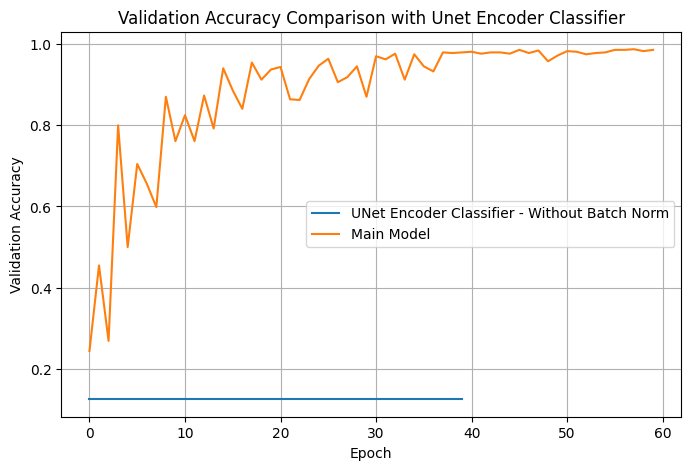

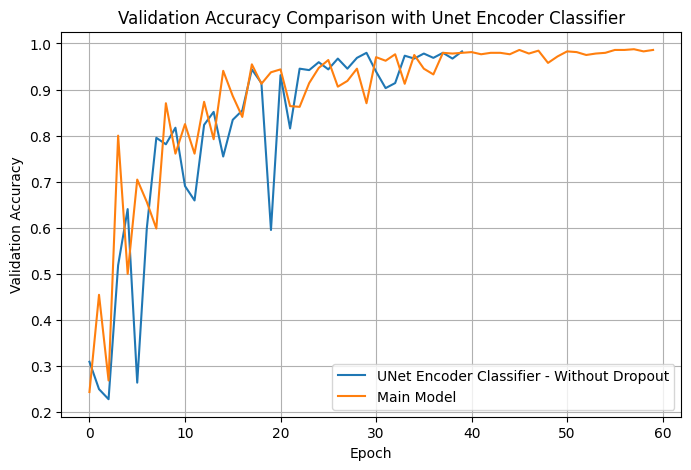

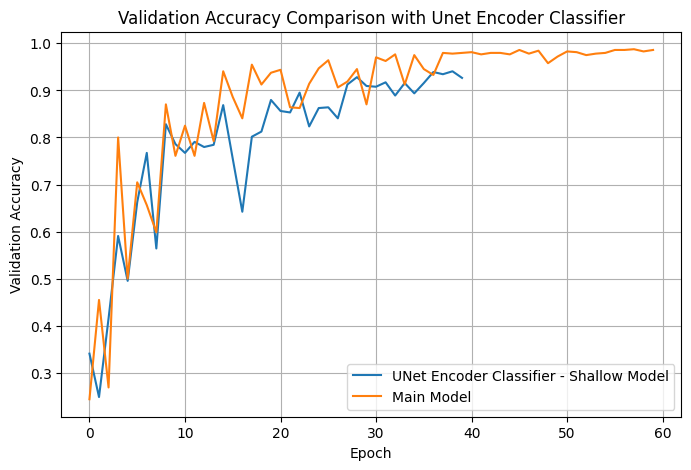

In [29]:
def plot_combined_validation_accuracy_ablation(h1, h2, labels):
    plt.figure(figsize=(8,5))

    plt.plot(h1["val_acc"], label=f"{labels[0]}")
    plt.plot(h2["val_acc"], label=f"{labels[1]}")

    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy Comparison with Unet Encoder Classifier")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_combined_validation_accuracy_ablation(
    ab1_history,
    main_history,
    labels=["UNet Encoder Classifier - Without Batch Norm", "Main Model"]
)

plot_combined_validation_accuracy_ablation(
    ab2_history,
    main_history,
    labels=["UNet Encoder Classifier - Without Dropout", "Main Model"]
)

plot_combined_validation_accuracy_ablation(
    ab3_history,
    main_history,
    labels=["UNet Encoder Classifier - Shallow Model", "Main Model"]
)